In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [17]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	'spread_line',
	'total_line',
]

adv_cols = ['stuffed','mediocre', 'explosive', 'huge_play', 'first_down', 'short_first', 'epa']

x_cols = game_context_cols + adv_cols #+ ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'touchdown', 'short_to_first'] # + rusher_stat_cols + ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [18]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,pbp.yards_gained + 40 as yards_shifted,
	case when pbp.down = 1 then 1 else 0 end as is_first_down,
	case when pbp.down = 2 then 1 else 0 end as is_second_down,
	case when pbp.down = 3 then 1 else 0 end as is_third_down,
	case when pbp.down = 4 then 1 else 0 end as is_fourth_down,
	pbp.first_down, pbp.touchdown
    ,rusher_player_name
    ,rusher_id,
                     pbp.season,
					 pbp.week,
                     fantasy_player_name,
                     qb_scramble,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	adv.*,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	--{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	--{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	--{Quack.select_columns(rusher_stat_cols, alias='r', coalesce=True)}
	from pbp 
	join rusher_adv as adv on pbp.rusher_player_id = adv.gsis_id
	and pbp.season = adv.season
	and pbp.week = adv.week
	--join team_feats as t 
	--on pbp.posteam = t.team
	--and pbp.game_id = t.game_id
	--join opp_feats as o
	--on pbp.defteam = o.opponent_team
	--and pbp.game_id = o.game_id
	--join player_weekly_agg as r
	--on r.game_id = pbp.game_id
	--and pbp.rusher_player_id = r.gsis_id
	--and r.team = pbp.posteam
	where pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
	and pbp.penalty = 0
	and pbp.fumble = 0
""")

rushes2 = rushes.copy()
mask = rushes.yards_gained < (rushes.yardline_100 - 10)
rushes2.loc[mask, 'yards_shifted'] += np.random.randint(-2,3, size=mask.sum())
print(len(rushes2))


267560


In [19]:
rushes[x_cols]

,yardline_100,ydstogo,down,goal_to_go,spread_line,total_line,stuffed,mediocre,explosive,huge_play,first_down,short_first,epa
0,20.0,10.0,1.0,0.0,5.5,41.5,0.164515,0.390727,0.148364,0.073198,0.0,0.700530,0.198745
1,1.0,1.0,4.0,1.0,5.5,41.5,0.272206,0.282133,0.096773,0.022086,0.0,0.645607,-0.177985
2,45.0,9.0,2.0,0.0,5.5,41.5,0.168699,0.282133,0.096773,0.022086,0.0,0.700311,0.008588
3,82.0,27.0,2.0,0.0,-3.0,46.0,0.181087,0.275554,0.123638,0.018171,0.0,0.716723,0.072199
4,40.0,9.0,2.0,0.0,3.0,37.5,0.204757,0.306508,0.118137,0.062442,1.0,0.700311,-0.151285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267555,46.0,10.0,1.0,0.0,-3.0,47.5,0.111054,0.298741,0.121499,0.026486,1.0,0.810795,0.098916
267556,31.0,6.0,2.0,0.0,6.5,48.5,0.132362,0.243986,0.154613,0.049362,0.0,0.772123,0.265837
267557,76.0,10.0,1.0,0.0,-3.0,47.5,0.111054,0.298741,0.121499,0.026486,0.0,0.810795,0.098916
267558,35.0,10.0,1.0,0.0,6.5,48.5,0.132362,0.243986,0.154613,0.049362,0.0,0.772123,0.265837


In [20]:
data = rushes #pd.concat((rushes, rushes2))
X = data[x_cols]
y = data['yards_shifted']
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
#X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
#y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [21]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	#smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.1)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	#criterion = FocalLoss(gamma=2)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCELoss()
	fd_criterion = nn.BCELoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=0.008)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices].to(device)
	Xtst = X[test_indices].to(device)
	train_y = y[train_indices].to(device)
	#train_y_smooth = smoothed_y[train_indices].to(device)
	test_y =  y[test_indices].to(device)
	#test_y_smooth = smoothed_y[test_indices].to(device)
	train_is_td = (y[train_indices] == (40 +  Xtr[:,0])).float()
	train_is_fd = (y[train_indices] >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]
			#batch_y_smooth =  train_y_smooth[batch_idx]
			batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)


			fd_mask = torch.arange(probs.size(1), device=device).unsqueeze(0) >= (batch_x[:,1] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			fd_output = (probs * fd_mask).sum(1)
			td_mask = torch.arange(probs.size(1),device=device).unsqueeze(0) >= (batch_x[:,0] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			td_output = (probs * td_mask).sum(1)
			td_loss = td_criterion(td_output, batch_td) * 2
			fd_loss = fd_criterion(fd_output, batch_fd) * 0.5

			probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y)
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) * 1.5
			loss = classifier_loss + mean_loss + td_loss + fd_loss
			#loss = classifier_loss + td_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()
		n_batches = len(range(0, Xtr.size(0), batch_size))
		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)
			test_loss = criterion(test_preds, test_y).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	return model

In [22]:
n_hidden = 128
n_in = len(x_cols)
n_out = 140
rush_yards_model = train_model(X_tensor,y_tensor, n_in=n_in, n_out=n_out, n_hidden=n_hidden, epochs=10, batch_size=2048)

#Test Loss: 2.3133, Test Accuracy: 0.1709 
#Test Loss: 2.8949, Test Accuracy: 0.1649 add label smoothing, no focal loss
#Test Loss: 2.4887, Test Accuracy: 0.1709 smoothing + focal + remove 1st down leakage
#Test Loss: 2.4681, Test Accuracy: 0.1682 maskedmodel2
#Test Loss: 2.4735, Test Accuracy: 0.1648 hierarchical thing
#Test Loss: 2.4042, Test Accuracy: 0.1596 
#Test Loss: 2.8056, Test Accuracy: 0.1470 fixed td bug, this looks best even w/ low acc. no focal loss or smooth labels
#Test Loss: 2.9683, Test Accuracy: 0.1199
#

cuda
tensors loading
splitting batches
tensor(0.2390, device='cuda:0')
tensor(0.0333, device='cuda:0')
Epoch 1/10, Classifier Loss: 5.2693, MSE Loss: 60.2475
Test Loss: 3.8741, Test Accuracy: 0.1390
Epoch 2/10, Classifier Loss: 4.4190, MSE Loss: 46.8762
Test Loss: 4.8780, Test Accuracy: 0.0698
Epoch 3/10, Classifier Loss: 4.5461, MSE Loss: 36.3487
Test Loss: 4.3666, Test Accuracy: 0.0720
Epoch 4/10, Classifier Loss: 4.0091, MSE Loss: 34.5355
Test Loss: 3.8276, Test Accuracy: 0.0743
Epoch 5/10, Classifier Loss: 3.5679, MSE Loss: 33.8360
Test Loss: 3.3870, Test Accuracy: 0.0726
Epoch 6/10, Classifier Loss: 3.2505, MSE Loss: 33.0684
Test Loss: 3.2496, Test Accuracy: 0.0747
Epoch 7/10, Classifier Loss: 3.1512, MSE Loss: 33.2272
Test Loss: 3.0977, Test Accuracy: 0.0807
Epoch 8/10, Classifier Loss: 3.0464, MSE Loss: 32.8367
Test Loss: 2.9898, Test Accuracy: 0.1135
Epoch 9/10, Classifier Loss: 2.9457, MSE Loss: 32.6508
Test Loss: 2.8756, Test Accuracy: 0.0979
Epoch 10/10, Classifier Loss: 2.8

In [23]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yards_model':{
	'feature_cols':x_cols,
	'n_hidden': n_hidden,
	'n_in': n_in,
	'n_out': n_out,
	'model_path': model_path
}
}
feature_config

update_config(feature_config)

true_first=0.11, true_td=0.06
fd_model=0.11, td_model=0.08
Actual mean: 3.79, Model mean: 3.29
number of datapoints: 1143


(-10.0, 34.0)

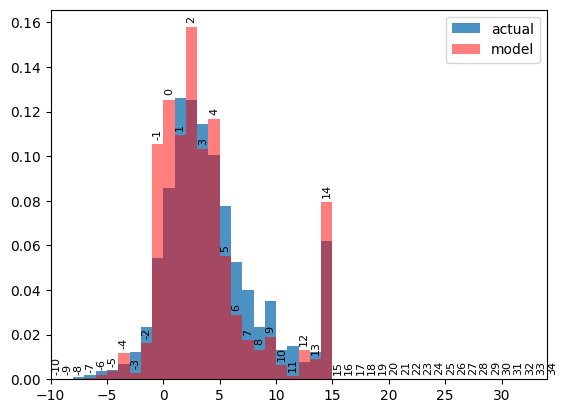

In [24]:
def get_ydl_chance(probs, ydl):

	cols = np.arange(probs.shape[1])
	mask = cols >= ydl[:, None]   # shape (3, 10), True where col >= start
	sums = (probs * mask).sum(axis=1).mean()
	return sums

def sample_model_yardline(yard, down):
	sample = rushes.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	probs = probs.mean(axis=0)
	

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 14
down = 2
probs = sample_model_yardline(yard, down)
plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')
3
# Add index labels on top of bars
for i, p in enumerate(probs):
	yard_val = -40 + i
	if -10 <= yard_val <= yard + 20:  # only label visible range
		plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
				 ha='center', va='bottom', fontsize=8, rotation=90)


plt.legend()
plt.xlim(-10,yard+20)

In [ ]:
def sample_model_yardline(yard, down):
	sample = rushes#.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	#y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	
	return probs

probs = sample_model_yardline(10,4)
probs

true_first=0.24, true_td=0.03
fd_model=0.20, td_model=0.03


array([[5.3603881e-09, 3.3938583e-08, 1.6210898e-08, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.5180244e-09, 1.8811765e-08, 1.6341794e-08, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.5976731e-11, 4.9860893e-10, 3.7345727e-10, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.4912492e-14, 5.3862730e-13, 9.5815977e-13, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.5987385e-10, 2.3135458e-09, 7.1727607e-10, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.3236881e-14, 8.7217348e-13, 1.0057648e-12, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], shape=(267560, 140), dtype=float32)

In [26]:
rushes['pred'] = torch.sum(torch.tensor((probs * np.arange(-40,100))),dim=1)
rushes

,desc,game_id,yards_gained,yards_shifted,is_first_down,is_second_down,is_third_down,is_fourth_down,first_down,touchdown,...,name,game_id_1,gsis_id,yardline_100,ydstogo,down,goal_to_go,spread_line,total_line,pred
0,(3:03) 30-A.Green up the middle to DET 19 for ...,2001_01_DET_GB,1.0,41.0,1,0,0,0,0.0,0.0,...,Ahman Green,2001_01_DET_GB,00-0006305,20.0,10.0,1.0,0.0,5.5,41.5,2.785076
1,(:21) 4-B.Favre up the middle to DET 2 for -1 ...,2001_01_DET_GB,-1.0,39.0,0,0,0,1,0.0,0.0,...,Brett Favre,2001_01_DET_GB,00-0005106,1.0,1.0,4.0,1.0,5.5,41.5,-0.284153
2,(2:00) 10-C.Batch right end to GB 38 for 7 yar...,2001_01_DET_GB,7.0,47.0,0,1,0,0,0.0,0.0,...,Charlie Batch,2001_01_DET_GB,00-0000865,45.0,9.0,2.0,0.0,5.5,41.5,2.161071
3,(12:34) 5-D.McNabb right end to PHI 26 for 8 y...,2001_01_STL_PHI,8.0,48.0,0,1,0,0,0.0,0.0,...,Donovan McNabb,2001_01_STL_PHI,00-0011022,82.0,27.0,2.0,0.0,-3.0,46.0,6.491563
4,(1:05) 28-F.Taylor left tackle to PIT 16 for 2...,2001_01_PIT_JAX,24.0,64.0,0,1,0,0,1.0,0.0,...,Fred Taylor,2001_01_PIT_JAX,00-0016098,40.0,9.0,2.0,0.0,3.0,37.5,17.838381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267555,(11:59) 5-R.Dowdle left tackle to DAL 34 for 1...,2025_06_DAL_CAR,12.0,52.0,1,0,0,0,1.0,0.0,...,Rico Dowdle,2025_06_DAL_CAR,00-0036139,46.0,10.0,1.0,0.0,-3.0,47.5,18.523251
267556,(11:50) (Shotgun) 28-J.Taylor up the middle to...,2025_10_ATL_IND,4.0,44.0,0,1,0,0,0.0,0.0,...,Jonathan Taylor,2025_10_ATL_IND,00-0036223,31.0,6.0,2.0,0.0,6.5,48.5,1.815108
267557,(13:17) 5-R.Dowdle left guard to CAR 33 for 9 ...,2025_06_DAL_CAR,9.0,49.0,1,0,0,0,0.0,0.0,...,Rico Dowdle,2025_06_DAL_CAR,00-0036139,76.0,10.0,1.0,0.0,-3.0,47.5,2.658641
267558,(12:29) 28-J.Taylor left end to ATL 31 for 4 y...,2025_10_ATL_IND,4.0,44.0,1,0,0,0,0.0,0.0,...,Jonathan Taylor,2025_10_ATL_IND,00-0036223,35.0,10.0,1.0,0.0,6.5,48.5,3.244941


In [27]:
rushes['RYOE'] = rushes['yards_gained'] - rushes['pred']


In [28]:
ex = rushes.loc[rushes.season ==2025].groupby(['rusher_player_name', 'qb_scramble'])['RYOE'].mean().reset_index().sort_values(by='RYOE')
cnt = rushes.loc[rushes.season == 2025]['rusher_player_name'].value_counts().reset_index()
ex = ex.merge(cnt)
ex.loc[(ex['count'] > 40) & (ex.qb_scramble == 0)].sort_values(by='RYOE').tail(30)

,rusher_player_name,qb_scramble,RYOE,count
159,J.Dobbins,0.0,0.319214,151
160,J.Croskey-Merritt,0.0,0.320269,112
161,D.Henry,0.0,0.323549,161
163,K.Williams,0.0,0.360800,154
164,B.Tuten,0.0,0.363581,60
165,R.Stevenson,0.0,0.365345,81
167,C.Hubbard,0.0,0.375936,89
169,S.Tucker,0.0,0.413435,50
171,E.Wilson,0.0,0.437726,53
174,A.Jones,0.0,0.448762,52


In [29]:
rushes.groupby(['qb_scramble'])[['yards_gained', 'RYOE']].mean()

,yards_gained,RYOE
qb_scramble,,
0.0,4.27713,0.136327
1.0,7.62065,0.136384


In [30]:
ex.loc[ex.rusher_player_name.str.contains('C.McCaff')].sort_values(by='week')

KeyError: 'week'

: 

: 

: 

: 

: 